In [8]:
import pandas as pd
import math
import gc
import pickle
from scipy.linalg import norm
from sklearn.preprocessing import normalize
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
import os
from itertools import combinations
import numpy as np
from random import seed, sample
import random
import numpy as np
from collections import Counter
import networkx as nx
import scipy.stats as stats


from scipy.stats import sem
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.decomposition import PCA



import itertools
from scipy.linalg import eigvalsh

#sys.path.append('/home/ll16598/Documents/Altered_States_Reddit/model_pipeline/__pycache__')
#from quality import reconst_qual, topic_diversity, coherence_centroid, coherence_pairwise #written for this jupyter notebook

In [9]:
test_mode=False
plot=False
if test_mode:
    save=False
else:
    save=True
print('TEST MODE')

threshold=244
# infile = open(f'/home/ll16598/Documents/POSTDOC/Context-DATM/sentenceBERT_cluster_dicts_{window}_{embedding_step}/cluster_dictionary_{save_thresh}','rb')
# cluster_dictionary=pickle.load(infile)
# infile.close()

user='luke'
if user=='luke':
    working_dir='/home/ll16598/Documents/POSTDOC/'
    dir_atom_dfs='/home/ll16598/Documents/POSTDOC/TDA/TDA_cluster/atom_assigned_dfs'

elif user=='cluster':
    working_dir='/N/u/lleckie/Quartz/TDA/'
    dir_atom_dfs=working_dir+'/atom_assigned_dfs'

dir_array='/home/ll16598/Documents/POSTDOC/TDA/TDA_cluster/vector_assigned_dfs'

#df_drug=pd.read_csv(f'.{}/df_monolog_{threshold}.csv')


TEST MODE


In [10]:
import spacy
import benepar
import nltk

# Ensure the benepar model is downloaded
benepar.download('benepar_en3')

# Load the spaCy model and add benepar to the pipeline (if not already added)
nlp = spacy.load("en_core_web_sm")
if "benepar" not in nlp.pipe_names:
    nlp.add_pipe("benepar", config={"model": "benepar_en3"}, last=True)

doc = nlp("This is a test sentence. Here is another one.")

for sent in doc.sents:
    # Get the parse string from the benepar extension attribute
    parse_str = sent._.parse_string
    # Convert the parse string to an nltk.Tree object
    tree = nltk.Tree.fromstring(parse_str)
    print(tree)


[nltk_data] Downloading package benepar_en3 to
[nltk_data]     /home/ll16598/nltk_data...
[nltk_data]   Package benepar_en3 is already up-to-date!
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


(S
  (NP (DT This))
  (VP (VBZ is) (NP (DT a) (NN test) (NN sentence)))
  (. .))
(SINV
  (ADVP (RB Here))
  (VP (VBZ is))
  (NP (DT another) (CD one))
  (. .))


In [11]:
from spacy.tokens import Span

if not Span.has_extension("parse_tree"):
    Span.set_extension("parse_tree", getter=lambda span: nltk.Tree.fromstring(span._.parse_string))

for sent in doc.sents:
    print(sent._.parse_tree)


(S
  (NP (DT This))
  (VP (VBZ is) (NP (DT a) (NN test) (NN sentence)))
  (. .))
(SINV
  (ADVP (RB Here))
  (VP (VBZ is))
  (NP (DT another) (CD one))
  (. .))


In [12]:
print(dir(doc.sents.__iter__().__next__()._))


['children', 'constituents', 'get', 'has', 'labels', 'parent', 'parse_string', 'parse_tree', 'set']


In [20]:
import spacy
import benepar
import nltk

# Download benepar model if not already downloaded
benepar.download('benepar_en3')

# Load spaCy model and add benepar to the pipeline (if not already present)
nlp = spacy.load("en_core_web_sm")
if "benepar" not in nlp.pipe_names:
    nlp.add_pipe("benepar", config={"model": "benepar_en3"}, last=True)

# Manually register the "parse_tree" extension on Span objects if not present.
from spacy.tokens import Span
if not Span.has_extension("parse_tree"):
    # Use the already registered "parse_string" from benepar and convert it to an nltk.Tree.
    Span.set_extension("parse_tree", getter=lambda span: nltk.Tree.fromstring(span._.parse_string))

def convert_to_chomsky(nltk_tree):
    """
    Convert an nltk.Tree (obtained from benepar) to Chomsky Normal Form.
    This modifies the tree in place.
    """
    nltk_tree.chomsky_normal_form(horzMarkov=2)
    return nltk_tree

def compute_syntactic_depth(nltk_tree):
    """
    Compute syntactic depth defined as the maximum number of edges from the root
    to a leaf. nltk.Tree.height() returns the number of nodes along the longest path,
    so we subtract one to get the number of edges.
    """
    return nltk_tree.height() - 1

def tree_size(nltk_tree):
    """
    Compute a measure of overall syntactic complexity by counting all nodes.
    """
    return sum(1 for _ in nltk_tree.subtrees())

import string
import nltk

def remove_punctuation(tree):
    """
    Recursively remove leaves that are punctuation.
    Returns a new tree without punctuation tokens.
    If all children are removed, returns None.
    """
    if isinstance(tree, nltk.Tree):
        new_children = []
        for child in tree:
            if isinstance(child, nltk.Tree):
                pruned_child = remove_punctuation(child)
                if pruned_child is not None:
                    new_children.append(pruned_child)
            else:
                # child is a leaf: if it's not punctuation, keep it.
                if child not in string.punctuation:
                    new_children.append(child)
        if not new_children:
            return None
        return nltk.Tree(tree.label(), new_children)
    else:
        return tree


def analyze_utterance(utterance):
    """
    Process an utterance (string) by:
      - Parsing it into sentences using spaCy+benepar.
      - Converting each sentence’s parse tree to Chomsky Normal Form.
      - Removing punctuation nodes for sequential analysis.
      - Computing syntactic depth and complexity.
    Returns lists of trees, depths, and complexity measures (one per sentence).
    """
    doc = nlp(utterance)
    trees = []
    depths = []
    complexities = []
    for sent in doc.sents:
        # Retrieve the parse tree via our custom extension.
        tree = sent._.parse_tree
        
        # Convert to Chomsky Normal Form
        tree_cnf = convert_to_chomsky(tree.copy())
        
        # Remove punctuation nodes for sequential analysis
        tree_pruned = remove_punctuation(tree_cnf)
        if tree_pruned is None:
            continue  # Skip if removal yields an empty tree
        
        # Compute syntactic depth and complexity
        depth = compute_syntactic_depth(tree_pruned)
        complexity = tree_size(tree_pruned)
        
        trees.append(tree_pruned)
        depths.append(depth)
        complexities.append(complexity)
    return trees, depths, complexities


# Example: Process a sample list of utterances.
sample_utterances = [
    'all right um so i was hoping you were gonna say becca.',
    'uh that’s my girlfriend and um she’s just a incredibly pleasant human being, just really, really nice um and uh warm uh and just really, really just a loving person.',
    'and um i think it’s i mean it’s interesting, to me at least, uh there’s not trying to convince myself that this is one of mine.'
]

# Process each utterance and print the results.
for idx, utterance in enumerate(sample_utterances):
    trees, depths, complexities = analyze_utterance(utterance)
    print(f"Utterance {idx+1}: {utterance}")
    for s_idx, (tree, depth, comp) in enumerate(zip(trees, depths, complexities)):
        print(f"  Sentence {s_idx+1} syntactic depth: {depth}")
        print(f"  Sentence {s_idx+1} syntactic complexity (node count): {comp}")
        print(tree)
    print("-" * 50)


import statistics
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

def compute_syntax_statistics(utterance_list, complexity_min=0):
    """
    Given a list of utterance strings, compute the descriptive statistics 
    (mean, median, mode, standard deviation) for syntactic depth and complexity.
    The analysis is done per utterance (which may consist of one or more sentences)
    and then aggregated (flattened) across the list.
    """
    all_depths = []
    all_complexities = []
    for utter in utterance_list:
        _, depths, complexities = analyze_utterance(utter)
        # Iterate over each sentence's depth and complexity:
        for d, c in zip(depths, complexities):
            if c > complexity_min:
                all_depths.append(d)
                all_complexities.append(c)
    
    # If no sentences were processed, return None values.
    if not all_depths:
        return {
            "depth_mean": None, "depth_median": None, "depth_mode": None, "depth_std": None,
            "complexity_mean": None, "complexity_median": None, "complexity_mode": None, "complexity_std": None,
        }
    
    # Compute statistics for syntactic depth.
    depth_mean = statistics.mean(all_depths)
    depth_median = statistics.median(all_depths)
    try:
        depth_mode = statistics.mode(all_depths)
    except statistics.StatisticsError:
        depth_mode = statistics.multimode(all_depths)[0]
    depth_std = statistics.stdev(all_depths) if len(all_depths) > 1 else 0

    # Compute statistics for syntactic complexity.
    complexity_mean = statistics.mean(all_complexities)
    complexity_median = statistics.median(all_complexities)
    try:
        complexity_mode = statistics.mode(all_complexities)
    except statistics.StatisticsError:
        complexity_mode = statistics.multimode(all_complexities)[0]
    complexity_std = statistics.stdev(all_complexities) if len(all_complexities) > 1 else 0

    return {
        "depths":all_depths,
        "depth_mean": depth_mean,
        "depth_median": depth_median,
        "depth_mode": depth_mode,
        "depth_std": depth_std,
        "complexity_mean": complexity_mean,
        "complexity_median": complexity_median,
        "complexity_mode": complexity_mode,
        "complexity_std": complexity_std,
    }


[nltk_data] Downloading package benepar_en3 to
[nltk_data]     /home/ll16598/nltk_data...
[nltk_data]   Package benepar_en3 is already up-to-date!
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Utterance 1: all right um so i was hoping you were gonna say becca.
  Sentence 1 syntactic depth: 13
  Sentence 1 syntactic complexity (node count): 30
(S
  (ADVP (ADVP (ADVP (DT all) (JJ right)) (PRP um)) (RB so))
  (S|<NP-VP>
    (NP (PRP i))
    (S|<VP-.>
      (VP
        (VBD was)
        (VP
          (VBG hoping)
          (SBAR
            (S
              (NP (PRP you))
              (VP
                (VBD were)
                (VP
                  (TO gon)
                  (VP (TO na) (VP (VB say) (NP (NN becca)))))))))))))
--------------------------------------------------
Utterance 2: uh that’s my girlfriend and um she’s just a incredibly pleasant human being, just really, really nice um and uh warm uh and just really, really just a loving person.
  Sentence 1 syntactic depth: 5
  Sentence 1 syntactic complexity (node count): 10
(S
  (UH uh)
  (S|<NP-VP>
    (NP (DT that))
    (VP (VBZ ’s) (NP (PRP$ my) (NN girlfriend)))))
  Sentence 2 syntactic depth: 22
  Sentence 2 s

MAY WANT TO CONSIDER REMOVING BACKCHANNEL COMMUNICATION

In [21]:
tqdm.pandas()

df_monologs=pd.read_csv(f'{dir_atom_dfs}/df_monolog_{threshold}.csv')
df_SER2=pd.read_csv(f'{dir_atom_dfs}/df_SER2_{threshold}.csv')
df_PEM=pd.read_csv(f'{dir_atom_dfs}/df_PEM.csv')
df_SER_MA=pd.read_csv(f'{dir_atom_dfs}/SER1.csv')

df_names=['SER_IPSP','SER1','PEM_df','SER_monologs']#, 'SER2']

data_save_dir=working_dir+'syntax_output/'
os.makedirs(data_save_dir, exist_ok=True)

completed_files=os.listdir(data_save_dir)
# for overlap in [0.1,0.2,0.4]:
#     for window in [60,80,100,120,140,160,180,200]:

layers='last'
dfs=[df_SER2,  df_SER_MA, df_PEM,df_monologs]
for df_no, df_monolog in enumerate(dfs):
    df_monolog['sentence_embeddings']=None
    df_name=df_names[df_no]
#             if 'monolog' not in df_name:
#                 continue

    with open(f'{dir_array}/utterance_{df_name}_utterances.pkl', 'rb') as f:
        embeds= pickle.load(f)   
    newfilename=f'{df_name}_utterance_syntax_results.csv'

    if len(embeds)!=len(df_monolog):
        raise Exception('MISMATCH IN LENGTH')

    print(len(embeds))
    print(len(df_monolog))
    df_monolog['utterances'] = embeds
    df_monolog['length'] = [len(i) for i in embeds]

    df_monolog = df_monolog[
        df_monolog["utterances"].apply(
            lambda x: (
                not isinstance(x, float)               # exclude floats
                and isinstance(x, (list, tuple, np.ndarray))  # must be list/tuple/np.ndarray
                and len(x) >= 3                        # length >= 3
            )
        )
    ]
    
    syntax_stats = df_monolog['utterances'].progress_apply(compute_syntax_statistics)
    syntax_stats_df = pd.json_normalize(syntax_stats)
    df_monolog = pd.concat([df_monolog, syntax_stats_df], axis=1)
        
    df_monolog.to_csv(data_save_dir + f'{df_name}_syntax_results.csv')
    
    # Exploding the DataFrame so that each row corresponds to a single depth value
    df_exploded = df_monolog.explode("depths", ignore_index=True)
    
    # Renaming the exploded column for clarity
    df_exploded = df_exploded.rename(columns={"depth_list": "Syntactic Depth"})
    df_exploded.to_csv(data_save_dir + f'{df_name}_exploded_syntax_results.csv')


107
107


100%|█████████████████████████████████████████| 107/107 [07:26<00:00,  4.18s/it]


108
108


100%|█████████████████████████████████████████| 108/108 [07:30<00:00,  4.17s/it]


130
130


100%|█████████████████████████████████████████| 130/130 [34:41<00:00, 16.01s/it]


101
101


100%|█████████████████████████████████████████| 100/100 [24:12<00:00, 14.53s/it]


In [23]:
list(df_monolog.columns)

['Unnamed: 0',
 'texts',
 'classification',
 'processed_text',
 'Drug',
 'sentence_embeddings',
 'utterances',
 'length',
 'depth_mean',
 'depth_median',
 'depth_mode',
 'depth_std',
 'complexity_mean',
 'complexity_median',
 'complexity_mode',
 'complexity_std']

In [34]:
import numpy as np
from scipy.stats import entropy
from pydmd import DMD

def compute_dmd_metrics(X, svd_rank=0, dt=1.0, eps=1e-5):
    """
    Compute various DMD-based metrics from time series X, 
    including indicators of system stability, attractor strength, and mode contributions.
    """
    if isinstance(X, float) or len(X) < 3:
        return {
            "mean_amplitudes": None,
            "energy_top2": None,
            "energy_top3": None,
            "largest_abs_eig": None,
            "dominant_frequency": None,
            "num_stable_eigs": None,
            "num_neutral_eigs": None,
            "num_unstable_eigs": None,
            "decay_rates_stable": None,
            "growth_rates_unstable": None,
            "modal_participation_ratio": None,
            "spectral_gap": None,
            "decay_spectral_index": None,
            "mode_amplitude_entropy": None,
            "koopman_condition_number": None
        }

    # Ensure shape (n, t) for PyDMD
    X_dmd = X.T  # shape (n, T)

    dmd = DMD(svd_rank=svd_rank)
    dmd.fit(X_dmd)

    eigs = dmd.eigs
    dynamics = dmd.dynamics
    modes = dmd.modes

    # Mean amplitude of each mode over time
    mean_amplitudes = np.mean(np.abs(dynamics), axis=1) if dynamics.size > 0 else np.array([])
    total_energy = np.sum(mean_amplitudes**2)
    sorted_inds = np.argsort(mean_amplitudes**2)[::-1] if len(mean_amplitudes) else []
    
    if total_energy > 0:
        top2_energy_fraction = np.sum(mean_amplitudes[sorted_inds[:2]]**2) / total_energy
        top3_energy_fraction = np.sum(mean_amplitudes[sorted_inds[:3]]**2) / total_energy
    else:
        top2_energy_fraction, top3_energy_fraction = 0, 0

    abs_eigs = np.abs(eigs) if len(eigs) else []
    largest_abs_eig = np.max(abs_eigs) if len(abs_eigs) > 0 else None

    # Dominant frequency for the mode with largest amplitude
    dom_freq_hz = None
    if len(sorted_inds) > 0:
        dom_index = sorted_inds[0]
        dom_eig = eigs[dom_index]
        dom_freq_hz = np.angle(dom_eig) / (2.0 * np.pi * dt)

    # Stability classification
    stable_inds, neutral_inds, unstable_inds = [], [], []
    for i, lam in enumerate(eigs):
        mag = np.abs(lam)
        if abs(mag - 1.0) <= eps:
            neutral_inds.append(i)
        elif mag < 1.0:
            stable_inds.append(i)
        else:
            unstable_inds.append(i)

    num_stable = len(stable_inds)
    num_neutral = len(neutral_inds)
    num_unstable = len(unstable_inds)

    decay_rates_stable = [1.0 - abs_eigs[i] for i in stable_inds]
    growth_rates_unstable = [abs_eigs[i] - 1.0 for i in unstable_inds]

    # === New Metrics ===

    # Modal Participation Ratio (MPR)
    if total_energy > 0:
        mpr = (np.sum(mean_amplitudes)**2) / np.sum(mean_amplitudes**4)
    else:
        mpr = None

    # Spectral Gap (|λ1| - |λ2|)
    spectral_gap = None
    if len(abs_eigs) > 1:
        sorted_eigs = np.sort(abs_eigs)[::-1]
        spectral_gap = sorted_eigs[0] - sorted_eigs[1]

    # Decay Spectral Index
    decay_spectral_index = np.sum(decay_rates_stable) / num_stable if num_stable > 0 else None

    # Mode Amplitude Entropy (Entropy of modal energy distribution)
    mode_amplitude_entropy = None
    if len(mean_amplitudes) > 0 and total_energy > 0:
        prob_dist = mean_amplitudes**2 / total_energy
        mode_amplitude_entropy = entropy(prob_dist)

    # Condition Number of Koopman Operator (High => More Sensitivity)
    koopman_condition_number = None
    if modes.shape[1] > 0:  # Ensure there are valid modes
        U, s, Vh = np.linalg.svd(modes, full_matrices=False)
        if len(s) > 0 and np.min(s) > 1e-10:
            koopman_condition_number = np.max(s) / np.min(s)
    
    metrics = {
        "mean_amplitudes": mean_amplitudes,
        "energy_top2": top2_energy_fraction,
        "energy_top3": top3_energy_fraction,
        "largest_abs_eig": largest_abs_eig,
        "dominant_frequency": dom_freq_hz,
        # Stability measures:
        "num_stable_eigs": num_stable,
        "num_neutral_eigs": num_neutral,
        "num_unstable_eigs": num_unstable,
        "decay_rates_stable": np.mean(decay_rates_stable),
        "growth_rates_unstable": np.mean(growth_rates_unstable),
        # New Metrics:
        "modal_participation_ratio": mpr,
        "spectral_gap": spectral_gap,
        "decay_spectral_index": decay_spectral_index,
        "mode_amplitude_entropy": mode_amplitude_entropy,
        "koopman_condition_number": koopman_condition_number
    }

    return metrics


In [36]:
data_save_dir

'/home/ll16598/Documents/POSTDOC/semantic_distance_output/'

In [38]:
tqdm.pandas()

df_monologs=pd.read_csv(f'{dir_atom_dfs}/df_monolog_{threshold}.csv')
df_SER2=pd.read_csv(f'{dir_atom_dfs}/df_SER2_{threshold}.csv')
df_PEM=pd.read_csv(f'{dir_atom_dfs}/df_PEM.csv')
df_SER_MA=pd.read_csv(f'{dir_atom_dfs}/SER1.csv')

df_names=['SER_IPSP','SER1','PEM_df','SER_monologs']#, 'SER2']
embeddings='sentence_embeddings'

data_save_dir=working_dir+'DMD_output/'
os.makedirs(data_save_dir, exist_ok=True)

completed_files=os.listdir(data_save_dir)
# for overlap in [0.1,0.2,0.4]:
#     for window in [60,80,100,120,140,160,180,200]:

for overlap in [0.1]:#,0.4]:
    for window in [100,80,60,40]:#,120,140]:#utterances
        
        layers='last'
        dfs=[df_SER2,  df_SER_MA, df_PEM,df_monologs]
        for df_no, df_monolog in enumerate(dfs):
            df_monolog['sentence_embeddings']=None
            df_name=df_names[df_no]
#             if 'monolog' not in df_name:
#                 continue
    
            if window=='utterances':
                with open(f'{dir_array}/utterance_{df_name}_sentence_embeddings_arrays.pkl', 'rb') as f:
                    embeds= pickle.load(f)   
                newfilename=f'{df_name}_utterance_distance_results.csv'

            else:
                step=int(window*overlap)#4
                with open(f'{dir_array}/{window}_{step}_{df_name}_sentence_embeddings_arrays.pkl', 'rb') as f:
                    embeds = pickle.load(f)   
                newfilename=f'{df_name}_{window}_{step}_distance_results.csv'
            
            if len(embeds)!=len(df_monolog):
                raise Exception('MISMATCH IN LENGTH')
                
            print(len(embeds))
            print(len(df_monolog))
            df_monolog['sentence_embeddings'] = embeds
            df_monolog['length'] = [len(i) for i in embeds]

            df_monolog = df_monolog[
                df_monolog["sentence_embeddings"].apply(
                    lambda x: (
                        not isinstance(x, float)               # exclude floats
                        and isinstance(x, (list, tuple, np.ndarray))  # must be list/tuple/np.ndarray
                        and len(x) >= 3                        # length >= 3
                    )
                )
            ]
            total_embed=get_all_embeddings

            dmd_data=[]
            for idx, row in df_monolog.iterrows():
                dmd_data.append(compute_dmd_metrics(row[embeddings], dt=step))
            df_dmd = pd.DataFrame(dmd_data)
            df_monolog = pd.concat([df_monolog, df_dmd], axis=1)
                        #             df_monolog['coverage'] = df_monolog['sentence_embeddings'].progress_apply(
#                 lambda subset: coverage(total_embed, subset)
#             )
            if window=='utterances':
                df_monolog.to_csv(data_save_dir + f'{df_name}_{window}_DMD_results.csv')
            else:
                df_monolog.to_csv(data_save_dir + f'{df_name}_{window}_{step}_DMD_results.csv')
            
            print('completed:', df_name, window)


107
107
completed: SER_IPSP 100
108
108


/home/ll16598/miniconda3/envs/SICC_AUG_22/lib/python3.8/site-packages/pydmd/dmd.py:14: DeprecationWarning: invalid escape sequence \l
  """
/home/ll16598/miniconda3/envs/SICC_AUG_22/lib/python3.8/site-packages/pydmd/dmdoperator.py:14: DeprecationWarning: invalid escape sequence \l
  """


KeyboardInterrupt: 

In [20]:
df_monologs=pd.read_csv(f'{dir_atom_dfs}/df_monolog_{threshold}.csv')
df_monologs['Drug']=df_drug['Drug']


In [22]:
df_monologs.to_csv(f'{dir_atom_dfs}/df_monolog_{threshold}.csv')


In [33]:
df_names=['SER_IPSP', 'SER1','SER_monologs']#, 'SER2']
embeddings='sentence_embeddings'

data_save_dir=working_dir+'semantic_distance_output/'
os.makedirs(data_save_dir, exist_ok=True)

completed_files=os.listdir(data_save_dir)
# for overlap in [0.1,0.2,0.4]:
#     for window in [60,80,100,120,140,160,180,200]:

for overlap in [0.1]:#,0.4]:
    for window in [100,80]:#,120,140]:
        step=int(window*overlap)#4
        layers='last'
        for df_no, df_name in enumerate(df_names):
            with open(f'{dir_array}/{window}_{step}_{df_name}_sentence_embeddings_arrays.pkl', 'rb') as f:
                embeds = pickle.load(f)    
            df_monolog=pd.read_csv(data_save_dir + f'{df_name}_{window}_{step}_distance_results.csv')
            
            df_monolog['length'] = [len(i) for i in embeds if len(i)>=3]
            
            #df_monolog.to_csv(data_save_dir + f'{df_name}_{window}_{step}_distance_results.csv')
            
            print('completed:', df_name, window, step)

completed: SER_IPSP 100 10
completed: SER1 100 10
completed: SER_monologs 100 10
completed: SER_IPSP 80 8
completed: SER1 80 8
completed: SER_monologs 80 8


In [34]:
df_monolog['length'] 

0     124
1      91
2      66
3     163
4      78
     ... 
68    100
69    101
70     66
71    141
72    105
Name: length, Length: 73, dtype: int64

In [24]:
 [len(i) for i in embeds]

[258,
 165,
 163,
 129,
 98,
 135,
 225,
 202,
 128,
 88,
 149,
 125,
 204,
 172,
 249,
 176,
 133,
 183,
 175,
 177,
 221,
 203,
 214,
 138,
 204,
 138,
 126,
 135,
 207,
 205,
 166,
 273,
 208,
 214,
 218,
 151,
 190,
 191,
 40,
 199,
 199,
 166,
 184,
 121,
 50,
 194,
 253,
 245,
 240,
 162,
 190,
 211,
 225,
 221,
 162,
 137,
 117,
 163,
 199,
 221,
 152,
 154,
 178,
 172,
 212,
 119,
 177,
 144,
 135,
 217,
 132,
 149,
 210,
 183,
 286,
 151,
 127,
 242,
 216,
 208,
 158,
 208,
 188,
 239,
 177,
 199,
 204,
 241,
 250,
 160,
 195,
 202,
 161,
 161,
 123,
 166,
 142,
 121,
 153,
 105,
 159,
 131,
 229,
 143,
 171,
 223,
 146,
 196,
 196,
 237,
 261,
 170,
 114,
 264,
 172,
 176,
 254,
 99,
 146,
 200,
 176,
 248,
 124,
 182,
 157,
 168,
 207,
 248,
 170,
 193,
 263,
 207,
 230]

In [16]:
df_monolog['length']

0      68
1      85
2      78
3      61
4      35
       ..
102    91
103    71
104    55
105    37
106    73
Name: length, Length: 107, dtype: int64

In [14]:
df_monolog

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,participant,participant_text,participant_list,confederate,confederate_list,...,semantic_density_mean_sentence_embeddings,semantic_density_entropy_sentence_embeddings,semantic_density_coeff_var_sentence_embeddings,conversational_distance_sentence_embeddings,av_distance_mean_sentence_embeddings,distance_list_sentence_embeddings,av_distance_entropy_sentence_embeddings,conversational_breadth_mean_sentence_embeddings,conversational_breadth_list_sentence_embeddings,conversational_breadth_entropy_sentence_embeddings
0,0,0,0,0,0,['SER202'],All right um so I was hoping you were gonna...,['All right um so I was hoping you were gon...,"Okay, this is SER202 session one IPSP. This i...","['Okay, this is SER202 session one IPSP. This...",...,0.667982,0.996842,0.220245,[[-0.62799615]],-0.944082,"[array([[-0.984278]], dtype=float32), array([[...",[[0.99984837]],-0.820284,"[array([[-0.78752685]], dtype=float32), array(...",[[0.99958956]]
1,1,1,1,1,1,['SER202'],"All right – all right, Mike – Mike [Inaudible...","['All right – all right, Mike – Mike [Inaudib...","Okay, this is SER202 session two IPSP. This i...","['Okay, this is SER202 session two IPSP. This...",...,0.503215,0.988894,0.417571,[[-0.40222767]],-0.928908,"[array([[-0.896093]], dtype=float32), array([[...",[[0.99980724]],-0.713484,"[array([[-0.6019161]], dtype=float32), array([...",[[0.9984305]]
2,2,2,2,2,2,['SER202'],"All right, um so Brad lived uh – we grew up to...","['All right, um so Brad lived uh – we grew up ...","Okay, this is SER202 session three IPSP. ...","['Okay, this is SER202 session three IPSP....",...,0.447204,-inf,0.558622,[[-0.3293913]],-0.927952,"[array([[-0.847363]], dtype=float32), array([[...",[[0.9997642]],-0.674011,"[array([[-0.7363819]], dtype=float32), array([...",[[0.9990234]]
3,3,3,3,3,3,['SER204'],"All right, first of all, I don’t really kno...","['All right, first of all, I don’t really k...","Okay, this is SER204 session one IPSP. This i...","['Okay, this is SER204 session one IPSP. This...",...,0.501032,0.987984,0.424029,[[-0.2592978]],-0.926281,"[array([[-0.9764817]], dtype=float32), array([...",[[0.99967074]],-0.713591,"[array([[-0.58699477]], dtype=float32), array(...",[[0.9983363]]
4,4,4,4,4,4,['SER204'],"[Noises] Guy Ritchie, um Snatch that movie; ye...","['[Noises] Guy Ritchie, um Snatch that movie; ...","Okay, this is SER204 uh session two IPSP. ...","['Okay, this is SER204 uh session two IPSP....",...,0.535689,0.982683,0.449122,[[-0.154116]],-0.922929,"[array([[-0.92406833]], dtype=float32), array(...",[[0.999478]],-0.740915,"[array([[-0.6277208]], dtype=float32), array([...",[[0.9982595]]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,102,102,102,102,102,['SER267'],"Okay. Uh, so Deacon is actually a friend o...","['Okay. Uh, so Deacon is actually a friend ...","Uh, subject ser267, session 2, date Sept...","['Uh, subject ser267, session 2, date Se...",...,0.431146,0.985241,0.504275,[[-0.18278189]],-0.922853,"[array([[-0.7395922]], dtype=float32), array([...",[[0.99959034]],-0.661360,"[array([[-0.6947805]], dtype=float32), array([...",[[0.9987]]
103,103,103,103,103,103,['SER267'],"Okay. Um, so Kevin – Kevin's an old drinki...","[""Okay. Um, so Kevin – Kevin's an old drin...","Date: October 6th, 2012 Subject: SER 267 Exp...","['Date: October 6th, 2012', 'Subject: SER 26...",...,0.531259,0.993776,0.320293,[[-0.29175413]],-0.918489,"[array([[-0.89663553]], dtype=float32), array(...",[[0.9994944]],-0.733390,"[array([[-0.6524808]], dtype=float32), array([...",[[0.99932325]]
104,104,104,104,104,104,['SER268'],"Uh, so this is, uh, my maternal grandfather. ...","['Uh, so this is, uh, my maternal grandfather....","This is SER 268, Session 1, IPSP. This is Sel...","['This is SER 268, Session 1, IPSP. This is S...",...,0.519741,0.990164,0.380935,[[-0.33448786]],-0.919710,"[array([[-0.911623]], dtype=float32), array([[...",[[0.9995732]],-0.726962,"[

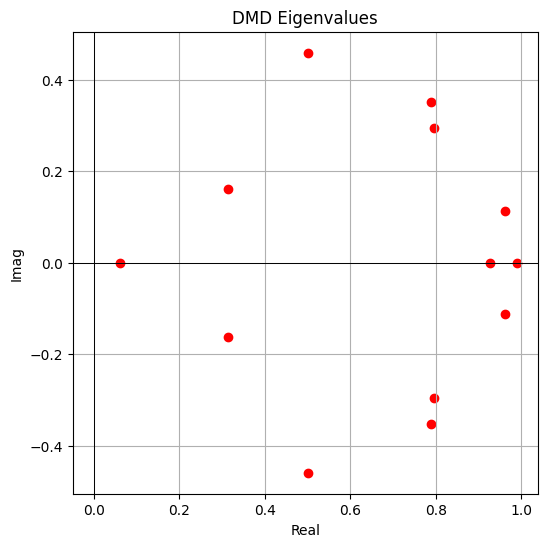

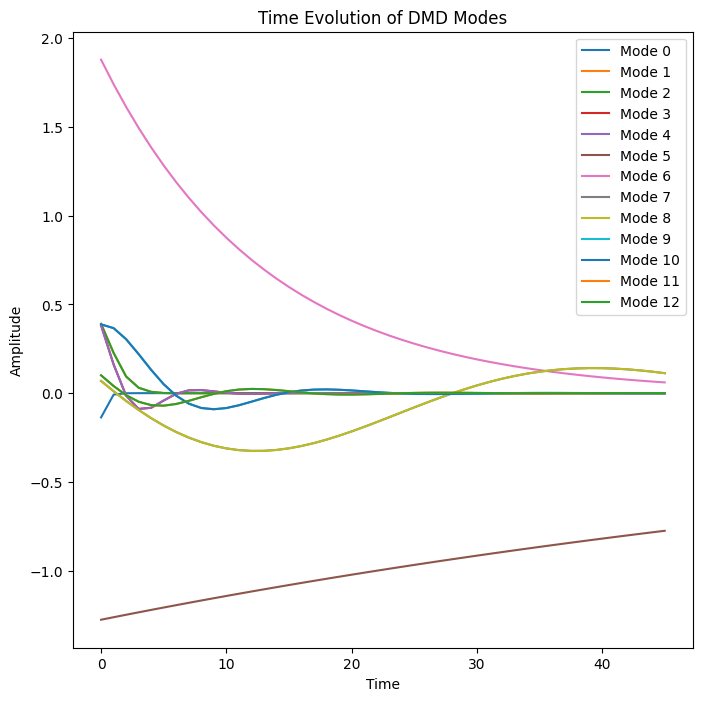

Relative reconstruction error: 3.7794e-01
Amplitudes: [-0.13641524+1.08049084e-16j  0.39039817-6.42915726e-01j
  0.39039817+6.42915726e-01j  0.38164103+6.36843368e-02j
  0.38164103-6.36843368e-02j -1.276425  -1.45716772e-16j
  1.8784316 +1.64798730e-16j  0.06879268+4.90993291e-01j
  0.06879268-4.90993291e-01j  0.387471  -1.96721241e-01j
  0.387471  +1.96721241e-01j  0.10041323+1.11012854e-01j
  0.10041323-1.11012854e-01j]

Eigenvalues sorted by magnitude:
Mode 5: eig=(0.9889838695526123+0j), |eig|=0.9889838695526123
Mode 7: eig=(0.9627888202667236+0.11298569291830063j), |eig|=0.9693957567214966
Mode 8: eig=(0.9627888202667236-0.11298569291830063j), |eig|=0.9693957567214966
Mode 6: eig=(0.9265252947807312+0j), |eig|=0.9265252947807312
Mode 11: eig=(0.7890545725822449+0.35224851965904236j), |eig|=0.8641100525856018
Mode 12: eig=(0.7890545725822449-0.35224851965904236j), |eig|=0.8641100525856018
Mode 9: eig=(0.7956375479698181+0.2949155271053314j), |eig|=0.8485365509986877
Mode 10: eig=(0

In [59]:

from pydmd import DMD
import matplotlib.pyplot as plt
# Y=np.array([1,2,3,4])
# Y2=np.array([Y,Y])
# -------------------------------------------------------
# 2. Fit the DMD model
# -------------------------------------------------------
dmd = DMD(svd_rank=0)
dmd.fit(X_transposed)

# -------------------------------------------------------
# 3. Visualize eigenvalues
# -------------------------------------------------------
eigs = dmd.eigs
plt.figure(figsize=(6,6))
plt.scatter(eigs.real, eigs.imag, color='red')
plt.axhline(0, color='black', linewidth=0.7)
plt.axvline(0, color='black', linewidth=0.7)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title('DMD Eigenvalues')
plt.grid(True)
plt.show()

# -------------------------------------------------------
# 4. Plot time dynamics for each mode
# -------------------------------------------------------
dynamics = dmd.dynamics
time_points = range(X_transposed.shape[1])
plt.figure()
for i in range(dynamics.shape[0]):
    plt.plot(time_points, dynamics[i].real, label=f'Mode {i}')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Time Evolution of DMD Modes')
plt.legend()
plt.show()

# -------------------------------------------------------
# 5. Check reconstruction error
# -------------------------------------------------------
X_rec = dmd.reconstructed_data
err = np.linalg.norm(X_transposed - X_rec) / np.linalg.norm(X_transposed)
print(f"Relative reconstruction error: {err:.4e}")

# -------------------------------------------------------
# 6. Extract features: amplitudes, frequencies, etc.
# -------------------------------------------------------
print("Amplitudes:", dmd.amplitudes)

magnitudes = np.abs(eigs)
sorted_indices = np.argsort(-magnitudes)
print("\nEigenvalues sorted by magnitude:")
for idx in sorted_indices:
    print(f"Mode {idx}: eig={eigs[idx]}, |eig|={magnitudes[idx]}")

# If you have a known delta_t:
delta_t = 0.01
eig_phases = np.angle(eigs)
frequencies_hz = eig_phases / (2 * np.pi * delta_t)
print("\nFrequencies in Hz:")
for i, freq in enumerate(frequencies_hz):
    print(f"Mode {i}: frequency = {freq:.4f} Hz")


In [81]:


import numpy as np




dmd_metrics = compute_dmd_metrics(X, svd_rank=0, dt=step)
print("DMD Metrics:")
for k, v in dmd_metrics.items():
    print(f"  {k} = {v}")


DMD Metrics:
  mean_amplitudes = [0.00315794 0.02528194 0.02528194 0.02622895 0.02622895 1.00563083
 0.53916722 0.2678777  0.2678777  0.062337   0.062337   0.02391764
 0.02391764]
  energy_top2 = 0.8935570986084618
  energy_top3 = 0.9428048284183033
  largest_abs_eig = 0.9889838695526123
  dominant_frequency = 0.0
  num_stable_eigs = 13
  num_neutral_eigs = 0
  num_unstable_eigs = 0
  decay_rates_stable = [0.9390770271420479, 0.6467621624469757, 0.6467621624469757, 0.3206861615180969, 0.3206861615180969, 0.011016130447387695, 0.0734747052192688, 0.030604243278503418, 0.030604243278503418, 0.15146344900131226, 0.15146344900131226, 0.1358899474143982, 0.1358899474143982]
  growth_rates_unstable = []


In [68]:
import numpy as np

def recurrence_plot(X, epsilon=None, norm='euclidean'):
    """
    Compute a basic recurrence plot for trajectory X.
    
    Parameters
    ----------
    X : np.ndarray
        Shape (T, n) => T time steps, n features/dimensions.
    epsilon : float, optional
        Recurrence threshold. If None, a default is chosen as 10% of max distance.
    norm : str, optional
        Distance metric for np.linalg.norm. Usually 'euclidean' is fine.
    
    Returns
    -------
    R : np.ndarray
        Recurrence matrix of shape (T, T), with 1 for recurrence, 0 otherwise.
    dist_matrix : np.ndarray
        The pairwise distance matrix, shape (T, T).
    """
    T = X.shape[0]
    dist_matrix = np.zeros((T, T), dtype=float)
    
    # Compute pairwise distances
    for i in range(T):
        for j in range(T):
            # Euclidean distance between states at times i and j
            dist_matrix[i, j] = cosine_similarity(X[i].reshape(1,-1), X[j].reshape(1,-1))
    
    # Choose a threshold if not provided (example: 10% of the max distance)
    if epsilon is None:
        epsilon = 0.1 * np.max(dist_matrix)
    
    # Create recurrence matrix
    R = (dist_matrix <= epsilon).astype(int)
    
    return R, dist_matrix

def recurrence_rate(R):
    """
    Recurrence rate = fraction of points in R that are 1.
    """
    return np.mean(R)

# Example usage:
# Suppose you have a trajectory shape (T, n) => 100 timesteps, 5D
R, distmat = recurrence_plot(X)#_transposed)

rr = recurrence_rate(R)
print("Recurrence Rate:", rr)

# You can plot the recurrence matrix as an image:
import matplotlib.pyplot as plt
plt.imshow(R, cmap='binary', origin='lower')
plt.title("Recurrence Plot")
plt.colorbar(label="Recurrence (0/1)")
plt.show()


ValueError: setting an array element with a sequence.

In [ ]:
df_monologs=pd.read_csv(f'{dir_atom_dfs}/df_monolog_{threshold}.csv')
df_SER2=pd.read_csv(f'{dir_atom_dfs}/df_SER2_{threshold}.csv')
df_PEM=pd.read_csv(f'{dir_atom_dfs}/df_PEM.csv')
df_SER_MA=pd.read_csv(f'{dir_atom_dfs}/SER1.csv')


df_names=['SER_monologs','SER_IPSP','PEM_df', 'SER_MA']#, 'SER2']
df_names=['SER_IPSP', 'SER_MA']#, 'SER2']

embeddings='sentence_embeddings'

data_save_dir=working_dir+'TDA_output/'
os.makedirs(data_save_dir, exist_ok=True)

completed_files=os.listdir(data_save_dir)
# for overlap in [0.1,0.2,0.4]:
#     for window in [60,80,100,120,140,160,180,200]:

for overlap in [0.1]:
    for window in [100]:
        step=int(window*overlap)#4
        layers='last'

        dfs=[df_monologs, df_SER2, df_PEM,df_SER_MA]#, df_SER, df_SER2]

        for df_no, df_monolog in enumerate(dfs):

            df_name=df_names[df_no]
            newfilename=f'{df_name}_{window}_{step}_TDA_results.csv'
#             if newfilename in completed_files:
#                 print(f'Already completed {newfilename}')
#                 continue

            with open(f'{dir_array}/{window}_{step}_{df_name}_sentence_embeddings_arrays.pkl', 'rb') as f:
                df_monolog['sentence_embeddings'] = pickle.load(f)
            if test_mode:
                df_monolog=df_monolog[0:10]
            drugs=sorted(list(set(df_monolog['Drug'])))
            Participants=sorted(list(set(df_monolog['Participant'])))
            
            df_monolog['token_embeddings']=None
            print('performing TDA on ',df_name, ' window: ', window, 'step: ', step)



            df_monolog=get_rips_time(df_monolog,embeddings=embeddings)
            df_monolog=get_rips_time_centroid(df_monolog,embeddings=embeddings)
            df_monolog=get_simplices_over_time(df_monolog,simplex_tree_type='simplex_tree')


            # Assuming df_monolog is your DataFrame and data_save_dir, df_name, window, and step are defined.
            # For each dimension (2, 3, 4) we explode the corresponding columns and then group by Drug and filtration values.

            for D in [2, 3, 4]:
                # Explode the lists in the columns for the current dimension.
                df_exploded = df_monolog.explode([f"simplex_time_dim{D}_filtration", f"simplex_time_dim{D}_count"])

                # Convert the exploded columns to numeric.
                df_exploded[f"simplex_time_dim{D}_filtration"] = pd.to_numeric(df_exploded[f"simplex_time_dim{D}_filtration"])
                df_exploded[f"simplex_time_dim{D}_count"] = pd.to_numeric(df_exploded[f"simplex_time_dim{D}_count"])

                # Group by "Drug" and the filtration values, and compute the mean and standard error for the counts.
                grouped = df_exploded.groupby(["Drug", f"simplex_time_dim{D}_filtration"], as_index=False).agg(
                    alive_mean=(f"simplex_time_dim{D}_count", "mean"),
                    alive_se=(f"simplex_time_dim{D}_count", sem)  # standard error
                )
                if save:
                    df_exploded.to_csv(data_save_dir + f'{df_name}_{window}_{step}_{D}_skeleton_simplices_over_time.csv', index=False)


                if plot:
                    import matplotlib.pyplot as plt
                    # Create a plot for the current dimension.
                    fig, ax = plt.subplots(figsize=(8, 6))

                    # Iterate over each drug group and plot mean ± SE.
                    for drug_level, df_sub in grouped.groupby("Drug"):
                        ax.errorbar(
                            df_sub[f"simplex_time_dim{D}_filtration"],
                            df_sub["alive_mean"],
                            yerr=df_sub["alive_se"],
                            label=f"Drug={drug_level}",
                            marker='o',
                            capsize=3
                        )

                    ax.set_xlabel("Filtration Value (Distance Threshold)")
                    ax.set_ylabel("Number of Alive Components (Mean ± SE)")
                    ax.set_title(f"Dimension {D} Alive Components Over Filtration Value by Drug")
                    ax.legend()
                    plt.show()

            for D in [0,1,2]:
                df_exploded = df_monolog.explode([f"scales_dim{D}", f'alive_dim{D}'])
                df_exploded[f"scales_dim{D}"] = pd.to_numeric(df_exploded[f"scales_dim{D}"])
                df_exploded[f'alive_dim{D}'] = pd.to_numeric(df_exploded[f'alive_dim{D}'])
                grouped = df_exploded.groupby(["Drug", f"scales_dim{D}"], as_index=False).agg(
                    alive_mean=(f'alive_dim{D}', "mean"),
                    alive_se=(f'alive_dim{D}', sem)  # standard error
                )
                df_exploded.to_csv(data_save_dir+f'{df_name}_{window}_{step}_{D}_simplices_over_time.csv')
                if plot:

                    fig, ax = plt.subplots(figsize=(8,6))

                    # We'll iterate over each drug and plot mean ± SE
                    for drug_level, df_sub in grouped.groupby("Drug"):
                        ax.errorbar(
                            df_sub[f"scales_dim{D}"], 
                            df_sub["alive_mean"], 
                            yerr=df_sub["alive_se"], 
                            label=f"Drug={drug_level}",
                            marker='o',
                            capsize=3
                        )

                    ax.set_xlabel("Scale (distance threshold)")
                    ax.set_ylabel("Number of Alive Components (Mean ± SE)")
                    ax.set_title("Connected Components Over Scale by Drug")
                    ax.legend()
                    plt.show()
            
            df_with_graph=get_rips_complex_G(df_monolog)
            df_with_graph['euler'] = df_with_graph['rt_simplex_tree'].apply(lambda st: compute_euler_characteristic(st, max_dim=4))
            # Apply the function to each graph in df_with_graph
            graph_metrics = df_with_graph['graph'].apply(compute_graph_metrics)
            graph_metrics_df = pd.DataFrame(graph_metrics.tolist())
            df_with_graph = pd.concat([df_with_graph, graph_metrics_df], axis=1)
            
            dimensions = [0, 1, 2]

            # We'll accumulate new rows in a list of dicts
            new_rows = []

            for idx, row in df_with_graph.iterrows():
                embed = row[embeddings]  # Adjust as needed
                # We’ll store births, deaths, pers LENGTHS in a dict keyed by dimension
                dim_dict = {
                    dim: {'births': [], 'deaths': [], 'pers': []}
                    for dim in dimensions
                }

                
                    
                # Build the Rips Complex for *this row only*
                rips_complex = gd.RipsComplex(points=embed, max_edge_length=5.0)
                simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)
                persistence = simplex_tree.persistence()

                # Collect intervals by dimension
                for dim, (b, d) in persistence:
                    if d == float('inf'):
                        continue
                    if dim in dimensions:
                        dim_dict[dim]['births'].append(b)
                        dim_dict[dim]['deaths'].append(d)
                        dim_dict[dim]['pers'].append(d - b)
                        
                        
                row_dict = row.to_dict()  # Start with original row's columns

                for dim in dimensions:
                    bdp = dim_dict[dim]
                    stats_dict = compute_distribution_stats(bdp['births'], bdp['deaths'], bdp['pers'])
                    # prefix each stat key with dim
                    for stat_key, stat_val in stats_dict.items():
                        row_dict[f"{stat_key}_dim{dim}"] = stat_val

                # Add row_dict to new_rows
                new_rows.append(row_dict)

            # Create a new DataFrame
            df_with_tda = pd.DataFrame(new_rows)
            df_with_tda.to_csv(data_save_dir + f'{df_name}_{window}_{step}_TDA_results.csv')
            print(f'completed! {df_name} window: {window} step size: {step}')

performing TDA on  SER_IPSP  window:  100 step:  10
